In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive

/content/drive


In [3]:
cd MyDrive/

/content/drive/MyDrive


In [4]:
cd Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [5]:
cd Deep Project/

/content/drive/MyDrive/Colab Notebooks/Deep Project


In [6]:
cd Emotion-Detection-RNN-master/

/content/drive/MyDrive/Colab Notebooks/Deep Project/Emotion-Detection-RNN-master


In [7]:
ls

'classification_output (1).gsheet'
 classification_output.csv
 classification_output.gsheet
 configuration.cfg
 configuration.cfg.gdoc
 crawl-300d-2M.vec
 data/
 Demo.csv
 emoji_dataset.csv
 Given_trained_models/
 handler.py
 handler-test.py
 model.png
 oldweights4layers/
 README.md
 test_configuration.cfg
 trained_models/
 vectors/
'weights_best[anger]crawl-300d-2M-subword.h5'
'weights_best[fear]crawl-300d-2M-subword.h5'
'weights_best[joy]crawl-300d-2M-subword.h5'
'weights_best[love]crawl-300d-2M-subword.h5'
'weights_best[sadness]crawl-300d-2M-subword.h5'
'weights_best[surprise]crawl-300d-2M-subword.h5'
'weights_best[thankfulness]crawl-300d-2M-subword.h5'
 WordsNotFound.txt


Imports


In [8]:
import os
import sys
import getopt
import gc
import time
import csv
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import regularizers
import os
import time
import gc
import re
import glob
import configparser

Reading files 

In [9]:
!pip install emoji==1.2.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 4.4 MB/s eta 0:00:00


In [10]:
config = configparser.RawConfigParser()
try:
    config.read('./configuration.cfg')
except:
    print("Couldn't read config file from ./configuration.cfg")
    exit()

embedding_file = config.get('Params', 'vectorspace')
#embedding_fileemoji = config.get ('Params', 'emoji')
dataset_File = config.get('Params', 'dataset')
traget_Emotion = config.get('Params', 'target_emotion')
max_features = int(config.get('Params', 'max_features'))
maxlen = int(config.get('Params', 'maxlen'))
batchsize = int(config.get('Params', 'batchsize'))
num_epochs = int(config.get('Params', 'num_epochs'))
print(dataset_File)

data/dataset.csv


In [11]:
import gensim

# Load the emoji2vec embeddings
emoji2vec_model = gensim.models.KeyedVectors.load_word2vec_format('vectors/emoji2vec.bin', binary=True)

In [12]:
print(emoji2vec_model)

KeyedVectors<vector_size=300, 1661 keys>


# **This is the function that convert emojis to sentence just in case we were not able to find emoji to unicode**

In [13]:
def convert_emoji_to_text(emoji):
    if emoji in emoji2vec_model.vocab:
        return emoji2vec_model.most_similar(emoji, topn=1)[0][0]
    else:
        return ''


# **This is a function that converts the emoji to its unicode**

In [14]:
import pandas as pd
import emoji

def replace_emoji(df):
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        # Loop through each character in the text column
        for char in row['text']:
            # Check if the character is an emoji
            if char in emoji.UNICODE_EMOJI:
                # Replace the emoji with its Unicode representation
                row['text'] = row['text'].replace(char, f' {emoji.demojize(char)[1:-1]} ')
        # Check if the emotion column exists and is not empty
        if 'emotion' in df.columns and pd.notna(row['emotion']):
            # Loop through each character in the emotion column
            for char in row['emotion']:
                # Check if the character is an emoji
                if char in emoji.UNICODE_EMOJI:
                    # Replace the emoji with its Unicode representation
                    row['emotion'] = row['emotion'].replace(char, f' {emoji.demojize(char)[1:-1]} ')
    return df


In [15]:
import pandas as pd
import random

emotions = ['joy', 'sadness', 'surprise', 'thankfulness', 'anger', 'love', 'fear']

data = {
    'id': [random.randint(111111111111111111, 999999999999999999) for i in range(100)],
    'text': [f'[{" ".join(chr(random.randint(128513, 128591)) for i in range(1))}]' for i in range(100)],
    'emotion': [f'[ {random.choice(emotions)} ]' for i in range(100)]
}

df = pd.DataFrame(data)

# Convert the id column to integer
df['id'] = df['id'].astype(int)

# Save the dataframe as a CSV file
df.to_csv('emoji_dataset.csv', index=False)


Seperates punctuations from words in given string x

In [16]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clead_data(x):
    x = str(x).strip().lower()
    for punct in puncts:
        x = x.replace(punct, ' %s ' % punct)
    return x

  loading the data

In [17]:
import emoji
import pandas as pd

def replace_emojis_with_unicode(dataframe):
    # Define a helper function to replace emojis
    print(dataframe)
    def replace_emoji(match):
        emoji_unicode = match.group()
        return emoji.demojize(emoji_unicode)

    # Apply the helper function to each cell in the DataFrame
    dataframe = dataframe.applymap(lambda cell: emoji.demojize(cell) if isinstance(cell, str) else cell)
    return dataframe


In [18]:

'''
Prepares Train, Validation, and Test set along with the vocabulary 
for a given target emotion
'''
def prepare_data(target_emotion = 'joy',other_emotions=None):
    dataset_all = pd.read_csv(dataset_File)
    dataset_all= replace_emoji(dataset_all)
    print(dataset_all)
    #print("THE dataset_all:")
    #print(dataset_all)
    ## cleans up the text and makes it lower case
    dataset_all["text"] = dataset_all["text"].apply(lambda x: clead_data(x))
        
    dataset_all["emotion"] = dataset_all["emotion"].apply(lambda x: clead_data(x))
    
    print('Number of unique tweets: {}'.format(len(dataset_all['id'].unique().tolist())))
    

    ## prints distribution of emotions in full dataset
    s = pd.Series(dataset_all['emotion'])
    print(s.value_counts())
    c= "d"
    for i in range(0,10600): ############## we changed it according to the avaliable dataset range
      dataset_all['emotion'][i] = dataset_all['emotion'][i].strip().strip('"').replace(" ","")#**********ALERT******mkansh feeh .strip('"')wala .replace elly b3daha
      c = dataset_all['emotion'][i]
      #print(c)
      #print(target_emotion)
      #print("**************************")
      #if c == target_emotion:
        #print("hi")
    ## select data based on a target emotion with random selection from others
    dataset_target = dataset_all.loc[dataset_all['emotion'] == target_emotion]
   
    #print("THE dataset_target:")
    #print(dataset_target)
    target_count = dataset_target['emotion'].count()
    #print("THE target_count:")
    #print(target_count)
    if other_emotions == None:
        dataset_other = dataset_all.loc[dataset_all['emotion'] != target_emotion].sample(target_count)#####
    else:
        dataset_other = dataset_all.loc[dataset_all['emotion'] == other_emotions].sample(target_count)##### remove n= and randomstate= mkanosh maegodeen
    
    ## assign float values to class labels
    dataset_target['emotion'] = 1.0
    dataset_other['emotion'] = 0.0
 

    dataset = pd.concat([dataset_target, dataset_other])
    
    ## prints distribution of emotions in selected dataset
    s = pd.Series(dataset['emotion'])
    print(s.value_counts())

    ## split to train, validation and test
    train_df, val_test_df = train_test_split(dataset, test_size=0.2, random_state=2018)  # .08 since the datasize is large enough.  #0.2 for 5k dataset
    test_df, val_df = train_test_split(val_test_df, test_size=0.5, random_state=2018)  #0.5 for 5k dataset
    
    
    ## prints distribution of emotions in train, validation and test sets
    s = pd.Series(train_df['emotion'])
    print('**************')
    print(s.value_counts())
    
    s = pd.Series(test_df['emotion'])
    print('**************')
    print(s.value_counts())

    s = pd.Series(val_df['emotion'])
    print('**************')
    print(s.value_counts())

    ## fill up the missing values
    all_X = dataset['text'].fillna("_##_").values
    train_X = train_df["text"].fillna("_##_").values
    val_X = val_df["text"].fillna("_##_").values
    test_X = test_df["text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(all_X))
    print('#### number of words: ')
    print(tokenizer.num_words)
    
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)
    all_X = tokenizer.texts_to_sequences(all_X)
    lengths = [len(l) for l in all_X]

    print('=========================================')

    # plt.hist(lengths, bins = 'auto')
    # plt.show()

    ## Pad the sentences. We need to pad the sequence with 0's to achieve consistent length across examples.
    train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=maxlen)
    val_X = tf.keras.preprocessing.sequence.pad_sequences(val_X, maxlen=maxlen)
    test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['emotion'].values
    val_y = val_df['emotion'].values
    test_y = test_df['emotion'].values
    print(type(train_y))

    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))
    tst_idx = np.random.permutation(len(test_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    test_X = test_X[tst_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]
    test_y = test_y[tst_idx]

    return train_X, val_X, test_X, train_y, val_y, test_y, tokenizer.word_index

In [19]:
print(pd.read_csv("data/dataset.csv"))

                          id  \
0       [149569891127660544]   
1       [144547020391194624]   
2       [138662274389901312]   
3       [148577813379825664]   
4       [148973134249332737]   
...                      ...   
124490  [147882763813519360]   
124491  [146469053408616448]   
124492  [139458576795172864]   
124493  [143400146410016769]   
124494  [144172617165840384]   

                                                     text          emotion  
0       [t-minus 10 minutes until interview timeeeee. ...          [fear]   
1       [It doesnt really make sense that the Big EAST...       [sadness]   
2       [&i was praying that you&me might end up toget...          [love]   
3       [A little attitude problem all good itll make ...          [love]   
4              [I think I miss my boyfriend.. :( #lonely]       [sadness]   
...                                                   ...              ...  
124490  [Me and Naiya are staying the night with my si...           [joy]   

create an embedding matrix for emojis 


In [20]:
def load_embedding_emoji(word_index, embedding_file):
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_file))
    embed_size_emoji = len(embeddings_index[next(iter(embeddings_index))])

    # Load the emoji2vec embeddings
    emoji2vec_model = gensim.models.KeyedVectors.load_word2vec_format('vectors/emoji2vec.bin', binary=True)

    # Create a new embedding matrix
    nb_words = min(max_features, len(word_index))
    emb_mean, emb_std = -0.005838499, 0.48782197
    embedding_matrix_emoji = np.random.normal(emb_mean, emb_std, (nb_words, embed_size_emoji))
    count = 0
    for word, i in word_index.items():
        if i >= max_features:
            continue
        if word in emoji2vec_model.key_to_index:
            # If the word is an emoji, convert it to its text representation
            text_representation = convert_emoji_to_text(word)
            if text_representation:
                embedding_vector = emoji2vec_model[text_representation]
                embedding_matrix[i-1] = embedding_vector
                count += 1
        elif word in embeddings_index:
            # If the word is not an emoji, use the existing embedding file
            embedding_vector = embeddings_index[word]
            embedding_matrix[i-1] = embedding_vector
            count += 1
    
    return embedding_matrix_emoji, embed_size_emoji



Create an embedding matrix in which we keep only the embeddings for words which are in our word_index


In [21]:
def load_embedding(word_index, embedding_file):

    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_file))
    embed_size = len(embeddings_index[next(iter(embeddings_index))])

    print(embedding_file)
    
    ## make sure all embeddings have the right format
    key_to_del = []
    for key, value in embeddings_index.items():
        if not len(value) == embed_size:
            key_to_del.append(key)
    
    for key in key_to_del:
        del embeddings_index[key]

    notFountWords = []
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = -0.005838499, 0.48782197
    embed_size = all_embs.shape[1]
    print("*****embedding Size********")
    print(embed_size)
    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    count = 0
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i-1] = embedding_vector
            count = count + 1
        else:
            notFountWords.append(word)
    
    with open('WordsNotFound.txt', 'w') as f:
        for item in notFountWords:
            f.write("%s\n" % item)

    print('# of embeding changed: ')
    print(count)
    return embedding_matrix, embed_size

In [22]:
def model_gru(embedding_matrix, embed_size): #embedding_matrix_emoji, embed_size_emoji ):

    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    #emoji2vec_embedding_layer = tf.keras.layers.Embedding(max_features, embed_size_emoji, weights=[embedding_matrix_emoji])(inp)

    #x= tf.keras.layers.Concatenate(axis=-1)([word_embedding_layer, emoji2vec_embedding_layer])


    # Add a Convolutional layer to extract features
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)#raga3 x mkana word embedding layer

 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)


    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    conc = tf.keras.layers.concatenate([avg_pool, max_pool])
    conc = tf.keras.layers.Dense(70, activation="relu")(conc)

    conc = tf.keras.layers.Dropout(0.5)(conc)
    outp = tf.keras.layers.Dense(1, activation="sigmoid")(conc)
    model = tf.keras.models.Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:

def train_model(model):
    embedding_name = os.path.splitext(os.path.basename(embedding_file))[0]
    fileName = 'weights_best' + traget_Emotion + embedding_name + '.h5'
    filepath = fileName
    # filepath = "weights_best.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]

    history = model.fit(train_X, train_y, batch_size=batchsize, epochs=num_epochs, validation_data=(val_X, val_y), callbacks=callbacks)
    model.load_weights(filepath)
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_val_y, pred_test_y

This function computes the best F1 score by looking at predictions.


In [24]:
def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        printout = "F1 score at threshold {0} is {1}".format(thresh, res)
        print(printout)

    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return best_f1, best_thresh

Plotting the graph

In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

                          id  \
0       [149569891127660544]   
1       [144547020391194624]   
2       [138662274389901312]   
3       [148577813379825664]   
4       [148973134249332737]   
...                      ...   
124490  [147882763813519360]   
124491  [146469053408616448]   
124492  [139458576795172864]   
124493  [143400146410016769]   
124494  [144172617165840384]   

                                                     text          emotion  
0       [t-minus 10 minutes until interview timeeeee. ...          [fear]   
1       [It doesnt really make sense that the Big EAST...       [sadness]   
2       [&i was praying that you&me might end up toget...          [love]   
3       [A little attitude problem all good itll make ...          [love]   
4              [I think I miss my boyfriend.. :( #lonely]       [sadness]   
...                                                   ...              ...  
124490  [Me and Naiya are staying the night with my si...           [joy]   

<ipython-input-18-70e7218960c2>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_target['emotion'] = 1.0


1.0    2257
0.0    2257
Name: emotion, dtype: int64
**************
0.0    1809
1.0    1802
Name: emotion, dtype: int64
**************
1.0    227
0.0    224
Name: emotion, dtype: int64
**************
1.0    228
0.0    224
Name: emotion, dtype: int64
#### number of words: 
3497
<class 'numpy.ndarray'>
vectors/crawl-300d-2M-subword.vec


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


*****embedding Size********
300
# of embeding changed: 
3317
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 300)      1049100     ['input_2[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 35, 32)       28832       ['embedding_1[0][0]']            
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 35, 70)      14490       ['conv1d_1[0][0]']               
 )                             

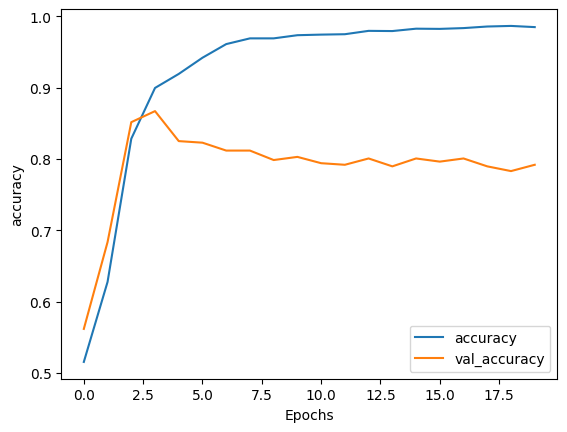

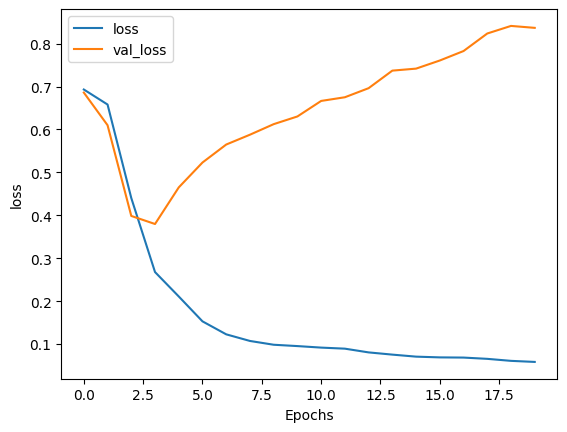

F1 score at threshold 0.1 is 0.8767123287671232
F1 score at threshold 0.11 is 0.8767123287671232
F1 score at threshold 0.12 is 0.8767123287671232
F1 score at threshold 0.13 is 0.8767123287671232
F1 score at threshold 0.14 is 0.8801571709233793
F1 score at threshold 0.15 is 0.8818897637795275
F1 score at threshold 0.16 is 0.8818897637795275
F1 score at threshold 0.17 is 0.8818897637795275
F1 score at threshold 0.18 is 0.8853754940711461
F1 score at threshold 0.19 is 0.8871287128712871
F1 score at threshold 0.2 is 0.8871287128712871
F1 score at threshold 0.21 is 0.8888888888888888
F1 score at threshold 0.22 is 0.8906560636182902
F1 score at threshold 0.23 is 0.8906560636182902
F1 score at threshold 0.24 is 0.8906560636182902
F1 score at threshold 0.25 is 0.8906560636182902
F1 score at threshold 0.26 is 0.8906560636182902
F1 score at threshold 0.27 is 0.8906560636182902
F1 score at threshold 0.28 is 0.8906560636182902
F1 score at threshold 0.29 is 0.8906560636182902
F1 score at threshold 

In [27]:
emotions = ['[anger]'] #space fy al dataset al 3adya msh emoji example [ '[ joy ]' ] 
for traget_Emotion in emotions:# *********ALERT******** ana 8ayart el max feature fel configuration mn 582 to 35 while training emojis
    train_X, val_X, test_X, train_y, val_y, test_y, word_index = prepare_data(traget_Emotion)
    embedding_matrix, embedding_size = load_embedding(word_index, embedding_file)
    #embedding_matrix_emoji, embedding_size_emoji = load_embedding_emoji(word_index, embedding_file)
    model1 = model_gru(embedding_matrix, embedding_size)# embedding_matrix_emoji, embedding_size_emoji)
    print(model1.summary())
    pred_val_y, pred_test_y = train_model(model1)
    f1, threshold = f1_smart(test_y, pred_test_y)
    printout = 'Optimal F1: {} at threshold: {}'.format(f1, threshold)
    print(printout)